# Imports/Set up

In [28]:
# Specific to NERSC: Set up kernel using: https://docs.nersc.gov/services/jupyter/how-to-guides/
from __future__ import annotations

import math
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import torch

# might have issues with too many files being opened at once
# this will prevent that
import torch.multiprocessing
from landscaper import LossLandscape
from landscaper import PyHessian
from neuralop import H1Loss
from neuralop import LpLoss
from neuralop.data.datasets.darcy import DarcyDataset
from neuralop.data.transforms.data_processors import IncrementalDataProcessor
from neuralop.models import FNO
from neuralop.training import AdamW
from neuralop.training.incremental import IncrementalFNOTrainer
from neuralop.utils import count_model_params
from neuralop.utils import get_project_root
from neuralop.utils import spectrum_2d
from torch.utils.data import DataLoader

torch.multiprocessing.set_sharing_strategy('file_system')

root_dir = get_project_root() / 'neuralop/data/datasets/data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

FIG_DIR = '../figures'

device=device(type='cuda')


# Train FNO

In [29]:
# first download data
data = DarcyDataset(
    root_dir=root_dir,
    n_train=100,
    n_tests=[32, 32, 32, 32],
    batch_size=16,
    test_batch_sizes=[16, 16, 16, 16],
    train_resolution=128,  # change resolution to download different data
    test_resolutions=[16, 32, 64, 128],
)

Loading test db for resolution 16 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 64 with 32 samples 
Loading test db for resolution 128 with 32 samples 


In [30]:
# load darcy flow dataset


def load_darcy_flow_small(
    n_train,
    n_tests,
    data_root=root_dir,
    test_resolutions=(16, 32),
    train_resolution=16,
):
    """Docstring."""
    batch_size = 16
    test_batch_sizes = [batch_size] * len(test_resolutions)

    dataset = DarcyDataset(
        root_dir=data_root,
        n_train=n_train,
        n_tests=n_tests,
        batch_size=batch_size,
        test_batch_sizes=test_batch_sizes,
        train_resolution=train_resolution,
        test_resolutions=test_resolutions,
        encode_input=False,
        encode_output=True,
        channel_dim=1,
        encoding='channel-wise',
        download=True,
    )

    # return dataloaders for backwards compat
    train_loader = DataLoader(
        dataset.train_db,
        batch_size=batch_size,
        num_workers=1,
        pin_memory=True,
        persistent_workers=False,
    )

    test_loaders = {}
    for res, test_bsize in zip(test_resolutions, test_batch_sizes):
        test_loaders[res] = DataLoader(
            dataset.test_dbs[res],
            batch_size=test_bsize,
            shuffle=False,
            num_workers=1,
            pin_memory=True,
            persistent_workers=False,
        )

    return train_loader, test_loaders, dataset.data_processor

In [31]:
df = pd.DataFrame(
    columns=[
        'train_resolution',
        'test_resolution',
        'loss_type',
        'loss',
        'max_modes',
    ],
)
max_modes = 16
train_resolution = 16

# get data
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
    n_train=1000,
    # batch_size=16,
    train_resolution=train_resolution,
    test_resolutions=[16, 32, 64, 128],
    n_tests=[100, 100, 100, 100],
    # test_batch_sizes=[32, 32, 32, 32],
)

# incrementally vary modes
incremental = True
starting_modes = (max_modes, max_modes)
if incremental:
    starting_modes = (2, 2)

# Set up model
model = FNO(
    max_n_modes=(max_modes, max_modes),
    n_modes=starting_modes,
    hidden_channels=32,
    in_channels=1,
    out_channels=1,
)
model = model.to(device)
n_params = count_model_params(model)

# optimizer + data
optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

data_transform = IncrementalDataProcessor(
    in_normalizer=None,
    out_normalizer=None,
    device=device,
    subsampling_rates=[2, 1],
    dataset_resolution=16,
    dataset_indices=[2, 3],
    epoch_gap=10,
    verbose=True,
)

data_transform = data_transform.to(device)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
train_loss = h1loss
eval_losses = {'h1': h1loss, 'l2': l2loss}
print('\n### N PARAMS ###\n', n_params)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print('\n### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()

# Finally pass all of these to the Trainer
trainer = IncrementalFNOTrainer(
    model=model,
    n_epochs=20,
    data_processor=data_transform,
    device=device,
    verbose=False,
    incremental_loss_gap=False,
    incremental_grad=True,
    incremental_grad_eps=0.9999,
    incremental_loss_eps=0.001,
    incremental_buffer=5,
    incremental_max_iter=1,
    incremental_grad_max_iter=2,
)

# train
end_stats = trainer.train(
    train_loader,
    test_loaders,
    optimizer,
    scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
)

model = trainer.model

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8

### N PARAMS ###
 2110305

### OPTIMIZER ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###

 * Train: <neuralop.losses.data_losses.H1Loss object at 0x7f091071d9f0>

 * Test: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x7f091071d9f0>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x7f091074d7b0>}
Incre Res Update: change index to 1
Incre Res Update: change sub to 1
Incre Res Update: change res to 16


# Loss Landscape Visualization

In [32]:
model = model.eval()
model

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 16]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 1, kernel_size=

In [53]:
def loss_function(model, data):
    """Custom loss func for loss landscape."""
    batch_loss = 0
    for _idx, sample in enumerate(data):  # resolution 128
        inputs, labels = sample
        inputs = inputs.to(device)
        labels = labels.to(device)
        # model_input = data_transform.preprocess(sample)
        with torch.no_grad():
            out = model(inputs)
            loss = criterion(out, labels)
            batch_loss += loss
    return batch_loss / len(data)


criterion = LpLoss(d=2, p=2)
net = model
inputs = []
labels = []
for _idx, sample in enumerate(test_loaders[128]):  # resolution 128
    inputs.append(sample['x'])
    labels.append(sample['y'])


inputs = torch.cat(inputs).to(device)
labels = torch.cat(labels).to(device)

data = []
for x, y in zip(inputs, labels):
    data.append((x.unsqueeze(dim=0), y.unsqueeze(dim=0)))

data = data  # [0:1]
# data = list(zip(inputs.unsqueeze(dim=0), labels.unsqueeze(dim=0)))

loss_function(model, data)

tensor(0.3536, device='cuda:0')

In [54]:
def generic_generator_a(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    data: Any,
    device: DeviceStr,
) -> Generator[tuple[int, torch.Tensor], None, None]:
    """Calculates the per-sample gradient for the model.

    Default implementation used for PyHessian; the underlying code expects that this generator
    returns the size of the input and the gradient tensor at each step.

    Args:
        model (torch.nn.Module): The model to calculate per-sample gradients for.
        criterion (torch.nn.Module): Function that calculates the loss for the model.
        data (Any): Source of data for the model.
        device (DeviceStr): Device used for pyTorch calculations.

    Yields:
        The size of the current input (int) and the gradient for that sample.
    """
    params = [p for p in model.parameters() if p.requires_grad]
    # print(len(params))
    model.zero_grad()  # clear gradients in case they were accumulated

    for sample, target in data:
        # don't use .to(device) here to avoid memory leaks
        # print(len(sample))
        outputs = model.forward(sample)
        # print(len(outputs))
        loss = criterion(outputs, target)
        # print(loss)
        # instead of loss.backward we directly compute the gradient to avoid overwriting the gradient in place
        grads = torch.autograd.grad(
            loss, params, create_graph=True, materialize_grads=True
        )
        # print(len(grads))
        yield sample.size(0), [g.real for g in grads]

In [55]:
import landscaper


def eigenvalues(hessian_comp, top_n):
    tol = 1e-3
    with torch.backends.cudnn.flags(enabled=False):
        device = hessian_comp.device
        eigenvalues = []
        eigenvectors = []

        computed_dim = 0

        while computed_dim < 3:
            eigenvalue = None
            v = [
                torch.randn(p.size()).to(device) for p in hessian_comp.params
            ]  # generate random vector
            v = landscaper.utils.normalization(v)  # normalize the vector

            for _ in range(100):
                v = landscaper.utils.orthnormal(v, eigenvectors)
                hessian_comp.model.zero_grad()

                tmp_eigenvalue, Hv = hessian_comp.hv_product(
                    [g.real for g in v]
                )
                v = landscaper.utils.normalization(Hv)

                if eigenvalue is None:
                    eigenvalue = tmp_eigenvalue
                elif (
                    abs(eigenvalue - tmp_eigenvalue) / (abs(eigenvalue) + 1e-6)
                    < tol
                ):
                    break
                else:
                    eigenvalue = tmp_eigenvalue
            eigenvalues.append(eigenvalue)
            eigenvectors.append([g.real for g in v])
            print(eigenvalue)
            print(computed_dim)
            computed_dim += 1

        return eigenvalues, eigenvectors

In [56]:
def generate_random_orthogonal_directions(model, n=3):
    directions = []
    while len(directions) != n:
        random_dir = [torch.randn_like(p.data) for p in model.parameters()]
        for prev_dir in directions:
            dot_product = sum(
                (d1 * d2).sum() for d1, d2 in zip(random_dir, prev_dir, strict=False)
            )

            for j, (d1, d2) in enumerate(zip(random_dir, prev_dir, strict=False)):
                random_dir[j] = d1 - dot_product * d2
        directions.append(random_dir)
    return directions

directions = generate_random_orthogonal_directions(model, n=3)

In [52]:
hessian_comp = PyHessian(
    net, criterion, data, device, hessian_generator=generic_generator_a
)

with torch.backends.cudnn.flags(enabled=False):
    evals, evecs = eigenvalues(hessian_comp, top_n=1)

directions = evecs
evals

(87978.5546875-0.20448581874370575j)
0


KeyboardInterrupt: 

In [57]:
"""Module for computing loss landscapes for PyTorch models."""

import copy
from collections.abc import Callable
from itertools import product

import numpy as np
import numpy.typing as npt
import torch
from landscaper.utils import DeviceStr
from tqdm import tqdm


# Helper functions for loss landscape computation
def get_model_parameters(model: torch.nn.Module) -> list[torch.Tensor]:
    """Get model parameters as a list of tensors.

    Args:
        model (torch.nn.Module): The PyTorch model whose parameters are to be retrieved.

    Returns:
        list[torch.Tensor]: List of model parameters.
    """
    return [p.data for p in model.parameters()]


def clone_parameters(parameters: list[torch.Tensor]) -> list[torch.Tensor]:
    """Clone model parameters to avoid modifying the original tensors.

    Args:
        parameters (list[torch.Tensor]): List of model parameters to clone.

    Returns:
        list[torch.Tensor]: List of cloned parameters.
    """
    return [p.clone() for p in parameters]


def add_direction(
    parameters: list[torch.Tensor], direction: list[torch.Tensor]
) -> None:
    """Add a direction to parameters in-place.

    Args:
        parameters (list[torch.Tensor]): List of model parameters to modify.
        direction (list[torch.Tensor]): List of direction tensors to add to the parameters.
    """
    for p, d in zip(parameters, direction, strict=False):
        p.add_(d.squeeze())


def sub_direction(
    parameters: list[torch.Tensor], direction: list[torch.Tensor]
) -> None:
    """Subtract a direction from parameters in-place.

    Args:
        parameters (list[torch.Tensor]): List of model parameters to modify.
        direction (list[torch.Tensor]): List of direction tensors to subtract from the parameters.
    """
    for p, d in zip(parameters, direction, strict=False):
        p.sub_(d.squeeze(0))


def scale_direction(
    direction: list[torch.Tensor], scale: float
) -> list[torch.Tensor]:
    """Scale a direction by a given factor.

    Args:
        direction (list[torch.Tensor]): List of direction tensors to scale.
        scale (float): Scaling factor.

    Returns:
        list[torch.Tensor]: Scaled direction tensors.
    """
    for d in direction:
        d.mul_(scale)
    return direction


def set_parameters(
    model: torch.nn.Module, parameters: list[torch.Tensor]
) -> None:
    """Set model parameters from a list of tensors.

    Args:
        model (torch.nn.Module): The PyTorch model whose parameters are to be set.
        parameters (list[torch.Tensor]): List of tensors to set as model parameters.
    """
    for p, new_p in zip(model.parameters(), parameters, strict=False):
        p.data.copy_(new_p)


def get_model_norm(parameters: list[torch.Tensor]) -> float:
    """Get L2 norm of parameters.

    Args:
        parameters (list[torch.Tensor]): List of model parameters.

    Returns:
        float: L2 norm of the model parameters.
    """
    return torch.Tensor(torch.sqrt(sum((p**2).sum() for p in parameters)).real)


def normalize_direction(
    direction: list[torch.Tensor], parameters: list[torch.Tensor]
) -> list[torch.Tensor]:
    """Normalize a direction based on the number of parameters.

    Args:
        direction (list[torch.Tensor]): List of direction tensors to normalize.
        parameters (list[torch.Tensor]): List of model parameters to use for normalization.

    Returns:
        list[torch.Tensor]: Normalized direction tensors.
    """
    for d, p in zip(direction, parameters, strict=False):
        d.mul_(
            torch.sqrt(
                torch.tensor(p.numel(), dtype=torch.float32, device=d.device)
            )
            / (d.norm() + 1e-10)
        )
    return direction


def compute_loss_landscape(
    model: torch.nn.Module,
    data: npt.ArrayLike,
    dirs: npt.ArrayLike,
    loss_function: Callable[[torch.nn.Module, npt.ArrayLike], float],
    steps=41,
    distance: float = 0.01,
    dim: int = 3,
    batch_size: int = 10,
    device: DeviceStr = 'cuda',
) -> tuple[npt.ArrayLike, npt.ArrayLike, npt.ArrayLike, npt.ArrayLike]:
    """Computes the loss landscape along the top-N eigenvector directions.

    Args:
        model (torch.nn.Module): The model to analyze.
        data (npt.ArrayLike): Data that will be used to evaluate the loss function for each point on the landscape.
        dirs (npt.ArrayLike): 2D array of directions to generate the landscape with.
        loss_function (Callable[[torch.nn.Module, npt.ArrayLike], float]): Loss function for the model.
            Should take the model and data as input and return a float loss value.
        steps (int): Number of steps in each dimension.
        distance (float): Total distance to travel in parameter space. Setting this value too high may lead to unreliable results.
        dim (int): Number of dimensions for the loss landscape (default: 3)
        batch_size (int): Batch size used to compute each point on landscape.
        device (Literal["cuda", "cpu"]): Device used to compute landscape.
    """
    # Get starting parameters and save original weights
    with torch.no_grad():
        start_point = get_model_parameters(model)
        original_weights = clone_parameters(start_point)

    try:
        coordinates = [
            np.linspace(-distance, distance, steps) for _ in range(dim)
        ]

        # Get top-N eigenvectors as directions
        directions = copy.deepcopy(dirs)
        if dim > len(directions):
            raise ValueError(
                f'Requested dimension {dim} exceeds available directions ({len(directions)}).'
            )

        # Normalize all directions
        for i in range(dim):
            directions[i] = normalize_direction(directions[i], start_point)

        # Scale directions to match steps and total distance
        model_norm = get_model_norm(start_point)
        for i in range(dim):
            dir_norm = get_model_norm(directions[i])
            scale_direction(
                directions[i], ((model_norm * distance) / steps) / dir_norm
            )

        # Move start point to corner (lowest point in all dimensions)
        current_point = clone_parameters(original_weights)
        for i in range(dim):
            scaled_dir = clone_parameters(directions[i])
            scale_direction(scaled_dir, steps / 2)
            sub_direction(current_point, scaled_dir)
            # Rescale direction vectors for stepping
            scale_direction(directions[i], 2.0 / steps)

        # Initialize loss hypercube - For dim dimensions, we need a dim-dimensional array
        loss_shape = tuple([steps] * dim)
        loss_hypercube = np.zeros(loss_shape)

        # Compute loss landscape - this is the core logic that needs to be efficient for N dimensions
        with torch.no_grad():
            # For very high dimensions, we'll need to be smarter about traversal
            # Rather than recursive approach, use an iterative approach with mesh grid

            # For dimensions > 5, we'll likely run out of memory with a full grid
            if dim > 5:
                print(
                    f'Warning: High dimensionality ({dim}) may require significant memory and computation time.'
                )
                print(
                    f"Consider reducing the 'steps' parameter (currently {steps}) or using a lower dimension."
                )
                # For very high dimensions, we might want to do random sampling instead

            # Generate grid coordinates

            grid_points = list(product(range(steps), repeat=dim))
            print(f'Computing {len(grid_points)} points in {dim}D space...')

            # Batch processing for efficiency - compute multiple grid points at once
            num_batches = (len(grid_points) + batch_size - 1) // batch_size

            # Initialize counters for averaging
            loss_counts = np.zeros(loss_shape, dtype=int)

            for batch_idx in tqdm(
                range(num_batches), desc=f'Computing {dim}D landscape'
            ):
                batch_start = batch_idx * batch_size
                batch_end = min((batch_idx + 1) * batch_size, len(grid_points))
                current_batch = grid_points[batch_start:batch_end]

                for grid_point in current_batch:
                    # Create a new parameter set for this grid point
                    point_params = clone_parameters(current_point)

                    # Move to the specified grid point by adding appropriate steps in each direction
                    for dim_idx, steps_in_dim in enumerate(grid_point):
                        for _ in range(steps_in_dim):
                            add_direction(point_params, directions[dim_idx])

                    # Set model parameters and compute loss
                    set_parameters(model, point_params)
                    with torch.no_grad():
                        loss = loss_function(model, data)

                    # Accumulate loss and increment counter for averaging
                    loss_hypercube[grid_point] += loss.item()
                    loss_counts[grid_point] += 1

                # Clear GPU memory
                if batch_idx % 5 == 0 and device == 'cuda':
                    torch.cuda.empty_cache()

            # Compute averages
            with np.errstate(divide='ignore', invalid='ignore'):
                loss_hypercube = np.divide(
                    loss_hypercube,
                    loss_counts,
                    where=loss_counts != 0,
                    out=np.zeros_like(loss_hypercube),
                )

        # Handle extreme values in loss surface
        loss_hypercube = np.nan_to_num(
            loss_hypercube,
            nan=np.nanmean(loss_hypercube),
            posinf=np.nanmax(loss_hypercube[~np.isinf(loss_hypercube)]),
            neginf=np.nanmin(loss_hypercube[~np.isinf(loss_hypercube)]),
        )

        # Print statistics about the loss hypercube
        print(
            f'Loss hypercube stats - min: {np.min(loss_hypercube)}, max: {np.max(loss_hypercube)}, '
            f'mean: {np.mean(loss_hypercube)}'
        )

    except Exception as e:
        print(f'Error during loss landscape computation: {e}.')
        import traceback

        traceback.print_exc()
    finally:
        # Restore original weights
        set_parameters(model, original_weights)

    # Handle extreme values in loss surface
    loss_hypercube = np.nan_to_num(
        loss_hypercube,
        nan=np.nanmean(loss_hypercube),
        posinf=np.nanmax(loss_hypercube[~np.isinf(loss_hypercube)]),
        neginf=np.nanmin(loss_hypercube[~np.isinf(loss_hypercube)]),
    )

    return loss_hypercube, coordinates

In [58]:
with torch.backends.cudnn.flags(enabled=False):
    landscape = compute_loss_landscape(
        model,
        data,
        [torch.Tensor(e[0].real) for e in directions],
        loss_function,  # loss function
        dim=2,
        distance=0.5, # 0.1
        device=device,
    )

# landscape.show()

Computing 1681 points in 2D space...


Computing 2D landscape: 100%|██████████| 169/169 [08:51<00:00,  3.15s/it]

Loss hypercube stats - min: 0.3306967616081238, max: 0.5578650236129761, mean: 0.3951243424365947


In [59]:
ls = LossLandscape(landscape[0], landscape[1])

Attempting log-scale surface plot...


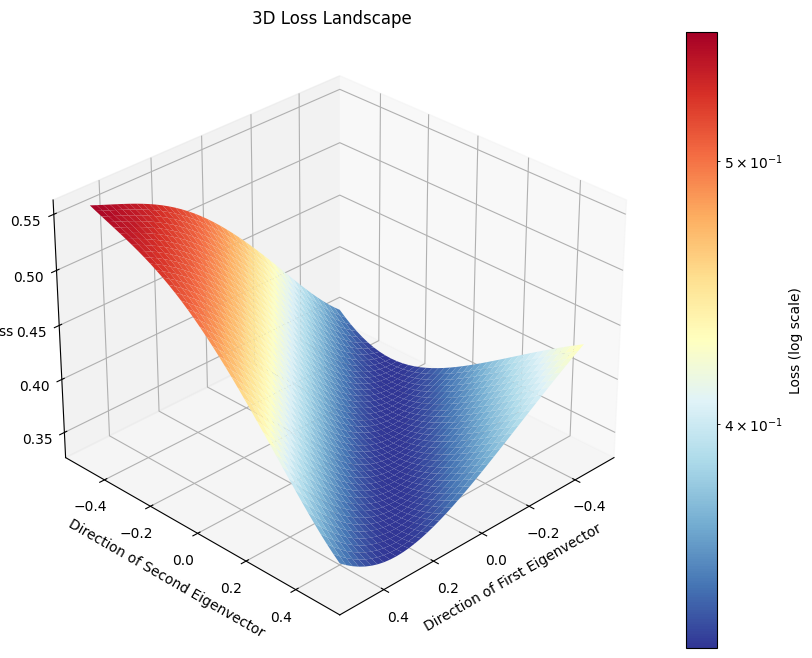

In [60]:
ls.show()

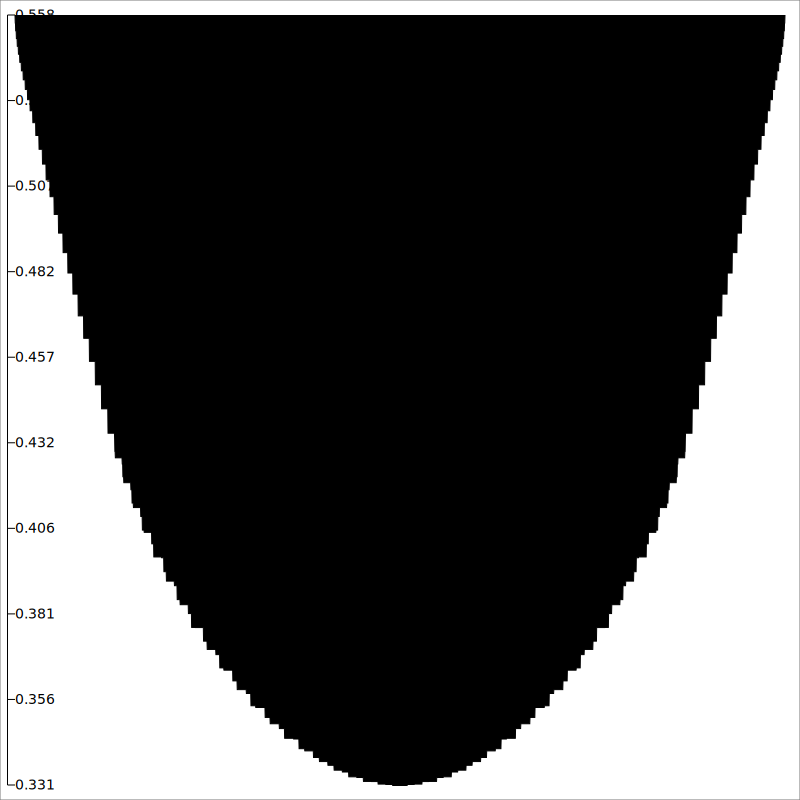

In [61]:
ls.show_profile()